# Question
Cases of a new epidemic have been detected. Use the Expectation Maximisation (EM) algorithm to train a Gaussian mixture model (GMM) of the data.


##  1. Dataset

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random

In [3]:
## Read data
filepath = './'
X = pd.read_table(filepath + 'EpidemicCases.txt', header=None, delimiter=None)
N, D = X.shape # Dimensions
X.head()

,0,1
0,0.607715,-0.775346
1,1.274766,-0.757605
2,1.390906,-0.583199
3,-0.490440,0.113664
4,0.584396,-0.612896


In [4]:
N,D

(250, 2)

## 2. Question a
Explain briefly the GMM model and the EM algorithm you are using

---

GMM model is applied to the dataset to cluster data points to different
groups. A GMM model assumes that all the data points in the dataset are
generated from a mixture of a finite number of Gaussian distributions.
Each Gaussian distribution in the mixture is comprised of the following
parameters:

-   A center mean $\mu$

-   A covariance matrix $\Sigma$

-   A weighted $\pi$ that is weighted of each Gaussian.

Therefore, the Gaussian mixture distribution can be written as a linear
combination of Gaussian functions in the form:
$$p(x) = \sum_{k=1}^{K}\pi_k\mathcal{N}(x|\mu_k,\Sigma_k)$$ where:  

-   K is the number of Gaussian distributions

-   $\mathcal{N}(x|\mu_k,\Sigma_k)$ is Gaussian density function that
    generate the probability of x given Gaussian k with mean $\mu_k$ and
    covariance matrix $\Sigma_k$

-   $\sum_{k=1}^{K}\pi_k = 1$

The log likelihood of the dataset takes the form:
$$ln p(x|\mu,\Sigma) = \sum_{n=1}^{N}ln\left\{\sum_{k=1}^{K}\pi_k\mathcal{N}(x|\mu_k,\Sigma_k)\right\}$$
In order to find the optimal parameters for GMM, we should maximize the
log likelihood.  
EM algorithm is applied to find the maximum likelihood of GMM models,
and therefore, get the optimal parameters of the models. The algorithm
starts with random values of parameters and repeats the process of
Evaluation - Maximization until log likelihood value converges to a
local optimum point. EM combines 4 steps:

-   Initiate step: Initiate the parameters for each Gaussian component
    and generate the initial value of log-likelihood.

-   Evaluate step: Evaluate the posterior probabilities using the
    current parameters

-   Maximization step: Re-estimate parameters using current posterior
    probabilities

-   Evaluate the log likelihood and check for convergence. If the
    algorithm isn’t converged, return to step 2.

At Evaluate step, the posterior probabilities of each Gaussian given a
data point is:
$$p(j|x_n) = \frac{p(x_n|\mu_j^{old}, \Sigma_j^{old})\pi_j^{old}}{\sum_{j=1}^{K}p(x_n|\mu_j^{old}, \Sigma_j^{old})\pi_j^{old}}$$
At Maximization step, the parameters are adjusted by the formula:
$$\begin{aligned}
    &\mu_j^{new} = \frac{\sum_{n=1}^N p(j|x_n,\mu^{old}, \Sigma^{old})x_n}{\sum_{n=1}^N p(j|x_n,\mu^{old}, \Sigma^{old})}
    \\
    & \Sigma_j^{new} = \frac{\sum_{n=1}^N p(j|x_n,=\mu^{old}, \Sigma^{old})(x_n-\mu_j^{new})^2}{\sum_{n=1}^N p(j|x_n,\mu^{old}, \Sigma^{old})}
    \\
    & \pi_j^{new} = \frac{1}{N}\sum_{n=1}^N p(j|x_n,\mu^{old}, \Sigma^{old})
\end{aligned}$$

## 3. Question b
Train a GMM of K = 3,4,5 Gaussians and plot the resulting mixture model. Plot the progression in likelihood values with respect to the iterations of the EM algo- rithm for the various cases.

---

In [27]:
def plot_gmm(X, means, covs, K, colors, filepath):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    x1 = np.linspace(x_min,x_max,200)  
    x2 = np.linspace(y_min,y_max,200)
    XX, YY = np.meshgrid(x1,x2) 
    
    Z = []
    for i in range(K):
        Z.append(multivariate_normal(means[i], covs[i])  )

    pos = np.empty(XX.shape + (2,))             
    pos[:, :, 0] = XX; pos[:, :, 1] = YY   

    plt.figure(figsize=(6,6))  # creating the figure and assigning the size
    plt.scatter(X[:,0], X[:,1], marker='o')    
    plt.scatter(means[:,0], means[:,1], marker = 'x', color = 'red', s = 120)
    for i in range(K):
        plt.contour(XX, YY, Z[i].pdf(pos), colors = colors[i] ,alpha = 0.5, linewidths=1,extend='both') 
  
    plt.axis('equal')  # making both the axis equal
    plt.xlabel('x', fontsize=16) # X-Axis
    plt.ylabel('y', fontsize=16) # Y-Axis
    plt.title('GMM for K = {}'.format(K))
    plt.grid()  # displaying gridlines
    plt.show()
        
def EM(X,K,M):
    #### Step 1: Initiate
    N, D = X.shape
    # Mean of Gaussian
    means = np.zeros((K,D))
    # p(Gaussian)
    pi = []
    for k in range(K):
        x1 = random.uniform(X[0].min(), X[0].max())
        x2 = random.uniform(X[1].min(), X[1].max())
        means[k] = [x1,x2]
        pi.append(random.randint(1,10))
    s = sum(pi)
    pi = np.array([x / s for x in pi])
    # Covariance matrix 
    covs = np.array([[[0.05,-0.03],[-0.03,0.05]]]*K )
    
    L = []
    for i in range(M):
        #### Step 2: Expectation
        # Prob of x given specific Gaussian, weighted by p(Gaussian)
        px_w = np.zeros((N,K)) 
        # Posterior of Gaussian given x
        pg = np.zeros((N,K)) 
        for k in range(K):
            px_w[:,k] = multivariate_normal.pdf(X,means[k],covs[k])*pi[k] 
        pg = px_w/np.sum(px_w, axis=1).reshape(-1,1)
        
        #### Step 3: Maximization 
        for k in range(K):
            pg_sum = pg[:,k].sum()
            # Mean
            num = X*pg[:,k].reshape(-1,1)
            means[k] = num.sum(axis = 0)/pg_sum
            # Covariance
            num = np.zeros((D,D))
            for n in range(N):
                num += np.dot((X[n:n+1,:] - means[k]).T, (X[n:n+1,:] - means[k]))*pg[n,k]
            covs[k] = num/pg_sum 
            # Prob
            pi[k] = pg_sum/N
        #### Step 4: Log likelihood
        L.append(np.sum(np.log(np.sum(px_w, axis=1))))
        
    # The last log likelihood value
    px_w = np.zeros((N,K)) 
    for k in range(K):
        px_w[:,k] = multivariate_normal.pdf(X,means[k],covs[k])*pi[k] 
    L.append(np.sum(np.log(np.sum(px_w, axis=1))))
    return(L,means,pi,covs)

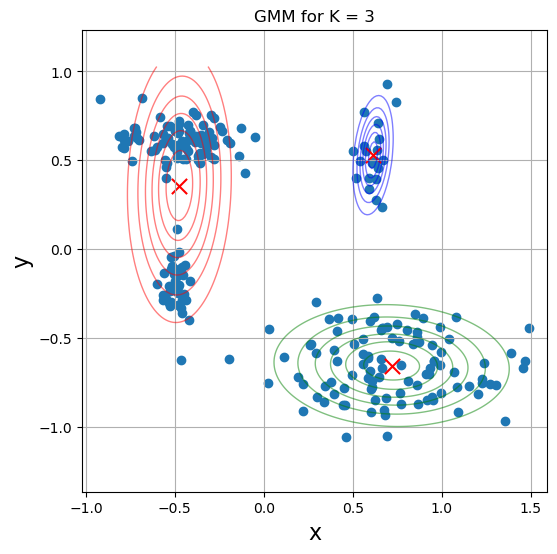

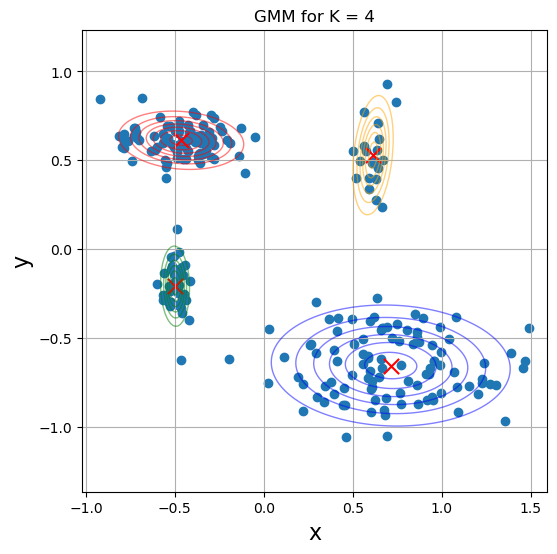

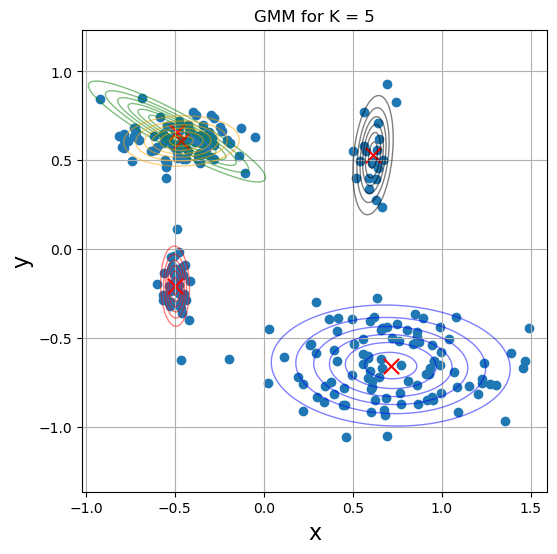

In [46]:
## Initiate
X = np.array(X)
colors = ['r', 'b', 'g', 'orange', 'black']
AIC,BIC,LL,Ls = [],[],[],[]
Ks = np.arange(3,6,1)
for K in Ks:
    M = 50 # Number of iterations 
    ## EM Algorithm
    L, means, pi, covs = EM(X,K,M)
    plot_gmm(X,means,covs,K,colors[:K],filepath + 'Gaussian{}'.format(K))
    Ls.append(L) # List of log likelihood values
    ## Loglikelihood
    LL.append(L[-1])
    ## AIC
    d = K*(D*(D+1)/2+D+1) - 1
    AIC.append(2*d - 2*LL[-1])
    ## BIC
    BIC.append(np.log(N)*d - 2*LL[-1])

In [47]:
print('Log likelihood of GMM in three cases K = 3,4,5 are:')
LL

Log likelihood of GMM in three cases K = 3,4,5 are:


[-191.66798381628004, -47.25530981071878, -43.956062300190496]

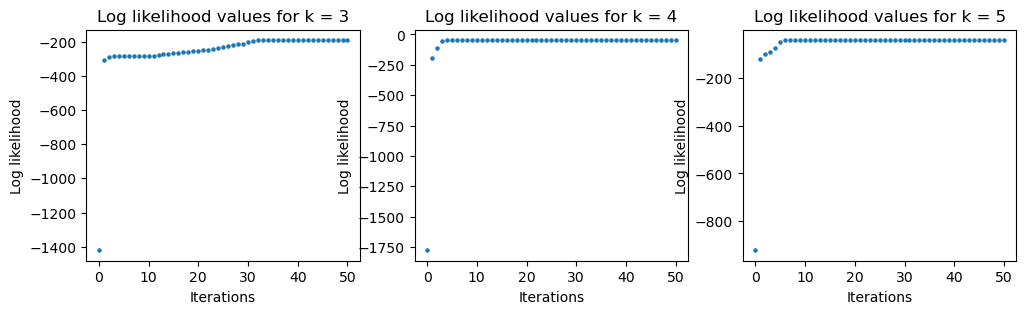

In [48]:
## Plot Log likelihood
fig, axes = plt.subplots(1,3,figsize = (12,3))
for ix,L in enumerate(Ls):
    ax = axes.flat[ix]
    ax.scatter(np.arange(M+1), L, s = 5)
    ax.set(xlabel = 'Iterations', ylabel = 'Log likelihood'
           , title = 'Log likelihood values for k = {}'.format(ix + 3))
plt.show()

## 4. Question c
Decide on the most likely number of Gaussians in the mixture, explain the criterion for your decision.

---

To decide on the most likely number of Gaussians in the mixture, along
with the maximum log-likelihood value, I use Akaike and Bayesian
Information Criterion (AIC and BIC) scores to quantify the performance
and complexity of the three models. Lower AIC, BIC scores, better the
model. The formula of AIC and BIC is: $$\begin{aligned}
  &AIC = -2* Log likelihood + 2 * k
  \\
  &BIC = -2 * Log likelihood + log(N) * k
\end{aligned}$$ where k is the number of parameters in the model, and N
is the number of data points in the train data set.  
For this GMM model, the number of parameters is the total elements in
$\mu, \Sigma, \pi$. Considering D as the number of
dimensions in the dataset, for each Gaussian, $\mu$ has D elements,
$\Sigma$ has $\frac{D*D-D}{2} + D = \frac{D(D+1)}{2}$ elements as it is
symmetric, $\pi$ has 1 element. It is important to notice that for K
Gaussians, we need only K-1 values of $\pi$ cause their total equals 1.
The total parameters of K Gaussian for dataset has D dimensions equals:
$$k = K(\frac{D(D+1)}{2}+D+1) - 1$$

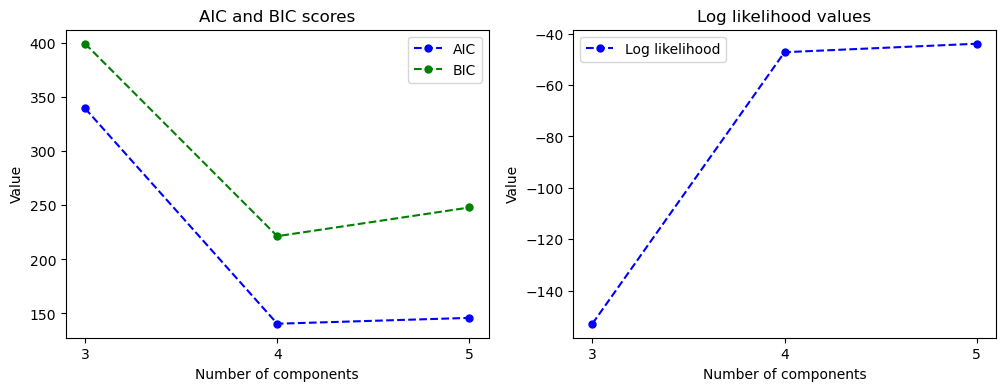

In [35]:
fig, axes = plt.subplots(1,2,figsize = (12,4))
axes[0].plot(Ks, AIC, '--.', color = 'blue', label = 'AIC', markersize = 10)
axes[0].plot(Ks, BIC, '--.', color = 'green', label = 'BIC', markersize = 10)
axes[0].legend()
axes[0].set(xlabel='Number of components', ylabel='Value', xticks=Ks
                , title = 'AIC and BIC scores')

axes[1].plot(Ks, LL, '--.', color = 'blue', label = 'Log likelihood', markersize = 10)
axes[1].legend()
axes[1].set(xlabel='Number of components', ylabel='Value', xticks=Ks
              , title = 'Log likelihood values')
plt.show()

Among the three numbers of components, GMM with K = 3 has the lowest value of log likelihood, K = 4 and K = 5 have far more better results.

Although GMM with 5 components has a greater log likelihood than GMM with 4 components, the difference isn’t significant. We need to look at AIC and BIC scores to choose the best version of GMM. GMM with 4 components has the lowest AIC and the lowest BIC scores among the three cases. 

In conclusion, 4 is the most likely number of Gaussians in the mixture.

## 5. Question d
Based on your results determine the coordinates of the points where the epidemic has originated from.

---


As we can cluster the datasets into 4 groups, the epidemic has 4 separate areas. The coordinates of the points where the epidemic has originated from are highly the center of the areas, which are the centers of 4 Gaussian distributions: ( 0.71, -0.65),(-0.499, -0.21),(0.61, 0.53),(-0.46, 0.61).